In [1]:
import sys
import os
import os.path as op
# from dipy.io.image import load_nifti
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchvision
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchio as tio
import numpy as np
import pytorch_lightning as pl
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


%matplotlib inline

In [2]:
data_path = op.join(sys.path[0], '../../Experiment1/001-AR/mean_for_seg.nii.gz')

In [3]:
# data, affine = load_nifti(data_path)
# img = nib.load(data_path).get_fdata()
img = tio.ScalarImage(data_path)
img

ScalarImage(shape: (1, 144, 48, 27); spacing: (0.97, 0.97, 3.00); orientation: LAS+; path: "/home/tim/OneDrive/Studium M. Sc/EPFL/Project/dev/SpinalcordSeg/../../Experiment1/001-AR/mean_for_seg.nii.gz")

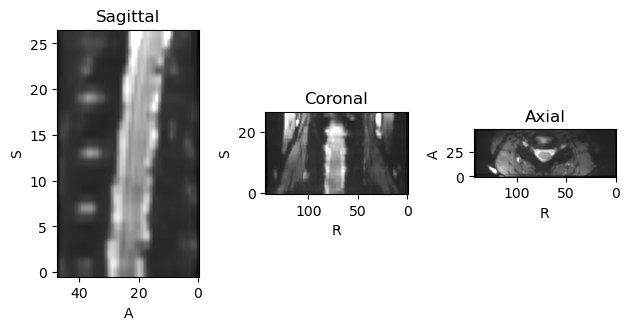

In [4]:
img.plot()

In [5]:
label_path = op.join(sys.path[0], '../../Experiment1/001-AR/mask_sc.nii.gz')

In [6]:
label = tio.LabelMap(label_path)
label

LabelMap(shape: (1, 144, 48, 27); spacing: (0.97, 0.97, 3.00); orientation: LAS+; path: "/home/tim/OneDrive/Studium M. Sc/EPFL/Project/dev/SpinalcordSeg/../../Experiment1/001-AR/mask_sc.nii.gz")

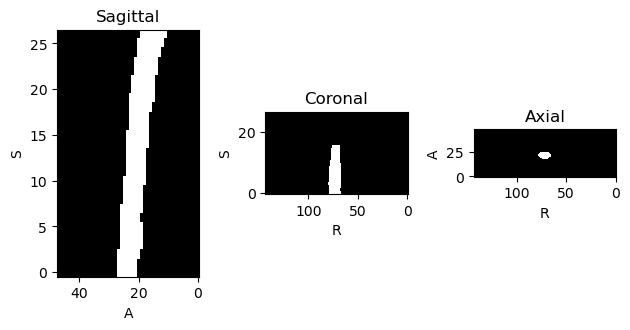

In [7]:
label.plot()

## Dataset creation

In [8]:
from torch.utils.data import Dataset

class SpinalCordDataset(Dataset):
    def __init__(self, annotations_files, img_files, transform=None, target_transform=None):
        self.img_labels = annotations_files
        self.img_files = img_files
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        image = img_file.data
        label = self.img_labels[idx].data
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [9]:
image_files = []
image_labels = []
test_images = []
test_labels = []

exp1_files = 12
np.random.seed(42)
indices = list(range(exp1_files))
np.random.shuffle(indices)

experiment1 = Path(op.join(sys.path[0], '../../Experiment1'))
experiment2 = Path(op.join(sys.path[0], '../../Experiment2'))
experiment3 = Path(op.join(sys.path[0], '../../Experiment3'))

index = 0
for file_path in experiment1.iterdir():
#     print(file_path)
    for image in file_path.rglob('*seg.nii.gz'):
        if index in indices[:2]:
            test_images.append(tio.ScalarImage(image))
        else:
            image_files.append(tio.ScalarImage(image))
    for label in file_path.rglob('*sc.nii.gz'):
        if index in indices[:2]:
            test_labels.append(tio.ScalarImage(label))
        else:
            image_labels.append(tio.ScalarImage(label))
    index += 1

index = 0
for file_path in experiment2.iterdir():
    for image in file_path.rglob('*mean.nii.gz'):
        if index in indices[:2]:
            test_images.append(tio.ScalarImage(image))
        else:
            image_files.append(tio.ScalarImage(image))
    for label in file_path.rglob('*sc.nii.gz'):
        if index in indices[:2]:
            test_labels.append(tio.ScalarImage(label))
        else:
            image_labels.append(tio.ScalarImage(label))
    index += 1

index = 0
for file_path in experiment3.iterdir():
    for image in file_path.rglob('*seg.nii.gz'):
        if index in indices[:2]:
            test_images.append(tio.ScalarImage(image))
        else:
            image_files.append(tio.ScalarImage(image))
    for label in file_path.rglob('*sc.nii.gz'):
        if index in indices[:2]:
            test_labels.append(tio.ScalarImage(label))
        else:
            image_labels.append(tio.ScalarImage(label))
    index += 1

In [10]:
# dataset = SpinalCordDataset(image_labels, image_files, tio.CropOrPad((144, 48, 35)), tio.CropOrPad((144, 48, 35)))
# test_set = SpinalCordDataset(test_labels, test_images, tio.CropOrPad((144, 48, 35)), tio.CropOrPad((144, 48, 35)))
dataset = SpinalCordDataset(image_labels, image_files, tio.CropOrPad((160, 64, 35)), tio.CropOrPad((160, 64, 35)))
test_set = SpinalCordDataset(test_labels, test_images, tio.CropOrPad((160, 64, 35)), tio.CropOrPad((160, 64, 35)))

In [11]:
validation_split = 0.15
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [12]:
train_loader = DataLoader(dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=16, sampler=valid_sampler)
test_loader = DataLoader(test_set, batch_size=16, shuffle=True)

In [13]:
for i, item in enumerate(train_loader):
    print('Batch {}'.format(i))
    image, label = item
    print(f"Datatype of Image: {type(image)}")
    print(f"Shape of the Image: {image.shape}")
    print(f"Label Values: {label}")
#     plt.imshow(label[0, 0,:,:,10])

Batch 0
Datatype of Image: <class 'torch.Tensor'>
Shape of the Image: torch.Size([16, 1, 160, 64, 35])
Label Values: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0

Batch 1
Datatype of Image: <class 'torch.Tensor'>
Shape of the Image: torch.Size([16, 1, 160, 64, 35])
Label Values: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0

## Model design

In [14]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
BACKBONE = 'resnet34'

In [15]:
model = smp.Unet(
    encoder_name=BACKBONE,
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
)

preprocess_input = get_preprocessing_fn(BACKBONE, pretrained='imagenet')

In [32]:
loss_func = smp.losses.DiceLoss('binary')
learning_rate = 1e-5
num_epochs = 20
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
model.train()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [33]:
# loss_0 = 0
iter_epoch = len(train_loader)
train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []
for epoch in range(num_epochs):
    for i, batch in enumerate(train_loader):
        image, label = batch
#         print(image.shape)
        inputs = image.reshape(image.shape[0], image.shape[1], 160, -1)
        labels = label.reshape(label.shape[0], label.shape[1], 160, -1)
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        train_loss_history.append(loss.detach().numpy())
        if i % 4 == 0:
            last_4_losses = train_loss_history[-4:]
            train_loss = np.mean(last_4_losses)
            print('Iteration {} Train loss: {}'.format(i + epoch*iter_epoch, train_loss))
            
        _, preds = torch.max(outputs, 1, keepdims=True)
        targets_mask = labels >= 0
        train_acc = np.mean((preds == labels)[targets_mask].numpy())
        train_acc_history.append(train_acc)
        print('Epoch %.3f Train acc/loss: %.3f/%.3f' % (epoch + 1, train_acc, train_loss))
    
    model.eval()
    
    val_losses = []
    val_scores = []
    for image, label in val_loader:
        inputs = image.reshape(image.shape[0], image.shape[1], 160, -1)
        labels = label.reshape(label.shape[0], label.shape[1], 160, -1)
        
        outputs = model.forward(inputs)
        loss = loss_func(outputs, labels)
        
        val_losses.append(loss.detach().numpy())
        _, preds = torch.max(outputs, 1, keepdims=True)
        targets_mask = labels >= 0
        val_score = np.mean((preds == labels)[targets_mask].numpy())
        val_scores.append(val_score)
    model.train()
    val_acc = np.mean(val_scores)
    val_loss = np.mean(val_losses)
    print('Epoch {} Val acc/loss {}/{}'.format(epoch + 1, val_acc, val_loss))

Iteration 0 Train loss: 0.040897369384765625
Epoch 1.000 Train acc/loss: 0.993/0.041
Epoch 1.000 Train acc/loss: 0.993/0.041
Epoch 1.000 Train acc/loss: 0.994/0.041
Epoch 1 Val acc/loss 0.9937569754464286/0.09884750843048096
Iteration 3 Train loss: 0.04252421855926514
Epoch 2.000 Train acc/loss: 0.993/0.043
Epoch 2.000 Train acc/loss: 0.993/0.043
Epoch 2.000 Train acc/loss: 0.993/0.043
Epoch 2 Val acc/loss 0.9937569754464286/0.09867829084396362
Iteration 6 Train loss: 0.04114276170730591
Epoch 3.000 Train acc/loss: 0.993/0.041
Epoch 3.000 Train acc/loss: 0.993/0.041
Epoch 3.000 Train acc/loss: 0.993/0.041
Epoch 3 Val acc/loss 0.9937569754464286/0.0998721718788147
Iteration 9 Train loss: 0.041763097047805786
Epoch 4.000 Train acc/loss: 0.993/0.042
Epoch 4.000 Train acc/loss: 0.993/0.042
Epoch 4.000 Train acc/loss: 0.993/0.042
Epoch 4 Val acc/loss 0.9937569754464286/0.09938490390777588
Iteration 12 Train loss: 0.04036213457584381
Epoch 5.000 Train acc/loss: 0.993/0.040
Epoch 5.000 Train 

In [34]:
def evaluate_model(model, dataloader):
    test_scores = []
    model.eval()
    for images, labels in dataloader:
        inputs = image.reshape(image.shape[0], image.shape[1], 160, -1)
        labels = label.reshape(label.shape[0], label.shape[1], 160, -1)
        
        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1, keepdims=True)
        targets_mask = labels >= 0
        test_scores.append(np.mean((preds.cpu() == labels.cpu())[targets_mask].numpy()))

    return np.mean(test_scores)

print(evaluate_model(model, test_loader))

0.9937569754464286


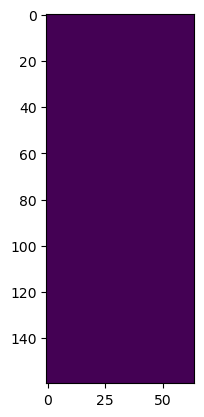

In [35]:
plt.imshow(preds[3, :, :, :].reshape(160, 64, 35).detach().numpy()[:, :, 15])